In [2]:
import os
os.chdir("../")

from MonteCarlo import MonteCarlo
from Black76 import Black76
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt

## Mini-projet I. Delta d'option

Ici on compare deux estimateurs de delta
$$
\mathbb{E}\left\{e^{-rT} \phi'(X_T^x)\dfrac{S_T^x}{x} \right\} \ \text{et} \ \mathbb{E}\left\{e^{-rT} \phi(X_T^x)\dfrac{W_T}{x\sigma T} \right\}.
$$

On compare aussi les variance de crude Monte Carlo et l'estimateur avec les variables de contrôle:
$$
\mathbb{E}\left\{e^{-rT} \phi'(X_T^x)\dfrac{S_T^x}{x} \right\} = \mathbb{E}\left\{e^{-rT} \phi'(X_T^x)\dfrac{S_T^x}{x} - e^{-rT} \left(\phi'(xe^{rT})\dfrac{S_T^x}{x} - \phi'(xe^{rT})e^{rT}\right)\right\}
$$
et
$$
\mathbb{E}\left\{e^{-rT} \phi(X_T^x)\dfrac{W_T}{x\sigma T} \right\} = \mathbb{E}\left\{e^{-rT} \left(\phi(X_T^x) - \phi(xe^{rT})\right)\dfrac{W_T}{x\sigma T} \right\}
$$
considerées dans le cours.

Enfin, nous appliquons la méthode adoptative pour poindrer la variable de contrôle:
$$
\tilde X_k = X_k - \lambda_{-k} \Xi_k,
$$
où $\Xi_k$ est une variable de contrôle et
$$
\lambda_{-k} = \dfrac{\sum_{i\not=k}X_i\Xi_i}{\sum_{i\not=k}\Xi_i^2},
$$
donc $\mathbb{E}\lambda_{-k} \Xi_k = 0$.

Au début, on prend en tant qu'une fonction $\phi$ le payoff d'option Call $\phi(x) = (x - K)^+$.

In [3]:
K = 100

def payoff_call(x, K=K):
    return np.maximum(x - K, 0)

def grad_payoff_call(x, K=K):
    return np.array(x - K >= 0, dtype='float')

In [4]:
def estimate_delta(
    phi: Callable,
    grad_phi: Callable,
    n_sample: int,
    T: float,
    S0: float,
    model: Black76,
    rng: np.random.Generator,
    ax: plt.axes,
    confidence_level: float = 0.95
):
    S_T, W_T = model.simulate_trajectory(
        size=n_sample,
        t_grid=[T],
        init_val=S0,
        flag="spot",
        rng=rng,
        return_brownian=True
    )

    sample_1 = np.exp(-model.r * T) * grad_phi(S_T) * S_T / S0
    sample_2 = np.exp(-model.r * T) * phi(S_T) * W_T / (S0 * model.sigma * T)

    F0 = S0 * np.exp(model.r*T)
    cv_1 = np.exp(-model.r * T) * grad_phi(F0) * (S_T - F0) / S0
    cv_2 = np.exp(-model.r * T) * phi(F0) * W_T / (S0 * model.sigma * T)

    sample_1_cv = sample_1 - cv_1
    sample_2_cv = sample_2 - cv_2

    mc_1 = MonteCarlo(sample=sample_1, confidence_level=confidence_level)
    mc_2 = MonteCarlo(sample=sample_2, confidence_level=confidence_level)

    mc_1_cv = MonteCarlo(sample=sample_1_cv, confidence_level=confidence_level)
    mc_2_cv = MonteCarlo(sample=sample_2_cv, confidence_level=confidence_level)

    mc_1_cv_adopt = MonteCarlo(sample=sample_1, confidence_level=confidence_level, control_variate=cv_1)
    mc_2_cv_adopt = MonteCarlo(sample=sample_2, confidence_level=confidence_level, control_variate=cv_2)

    print('Standard method:', mc_1.results(6))
    print('Standard method with c.v.:', mc_1_cv.results(6))
    print('Standard method, adopted c.v. weights:', mc_1_cv_adopt.results(6))
    print('Method using Stein lemma:', mc_2.results(6))
    print('Method using Stein lemma with c.v.:', mc_2_cv.results(6))
    print('Method using Stein, adopted c.v. weights:', mc_2_cv_adopt.results(6))

    mc_1.convergence_diagram(step=1000, ax=ax, log=True, color='b', label='Standard')
    mc_1_cv.convergence_diagram(step=1000, ax=ax, log=True, color='b--', label='Standard, control variate')
    mc_1_cv_adopt.convergence_diagram(step=1000, ax=ax, log=True, color='b:', label='Standard, adopted weights')
    mc_2.convergence_diagram(step=1000, ax=ax, log=True, color='g', label='Stein')
    mc_2_cv.convergence_diagram(step=1000, ax=ax, log=True, color='g--', label='Stein, control variate')
    mc_2_cv_adopt.convergence_diagram(step=1000, ax=ax, log=True, color='g:', label='Stein, adopted weights')
    ax.set_title('Convergence diagrams')

In [5]:
r = 0.05
sigma = 0.2

model = Black76(sigma, r)

Analytic delta: 0.6896910267811552
Standard method: 0.689717 ± 0.000378
Standard method with c.v.: 0.689724 ± 0.000232
Standard method, adopted c.v. weights: 0.68973 ± 0.00017
Method using Stein lemma: 0.689385 ± 0.001004
Method using Stein lemma with c.v.: 0.689369 ± 0.000874
Method using Stein, adopted c.v. weights: 0.689332 ± 0.000727


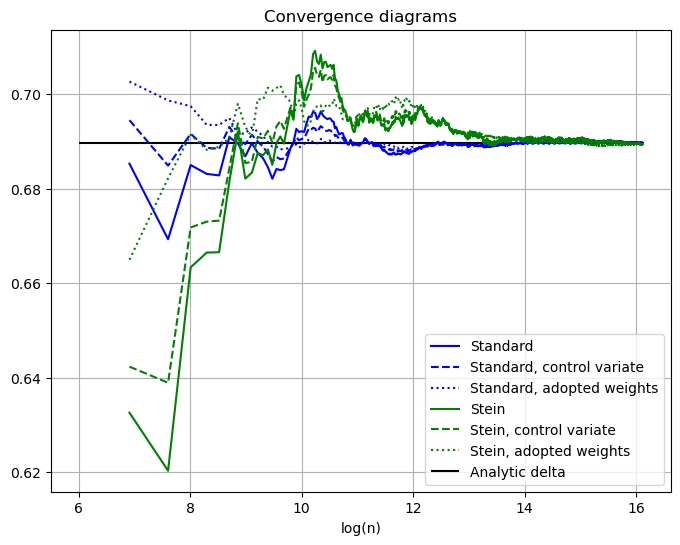

In [6]:
rng = np.random.default_rng(seed=42)

fig, ax = plt.subplots(figsize=(8, 6))

n_sample = 10**7

S0 = 100
T = 2

F0 = S0 * np.exp(r*T)

delta = model.delta(T, K, F0, 'c')
print('Analytic delta:', delta)
ax.hlines(delta, 6, np.log(n_sample), 'k', label='Analytic delta')

estimate_delta(
    phi=payoff_call,
    grad_phi=grad_payoff_call,
    n_sample=n_sample,
    T=T,
    S0=S0,
    model=model,
    rng=rng,
    ax=ax
)

On voit que la méthod adoptative démontre les meilleurs résultats et que le premier estimateur a une plus petite variance.

Maintenant on considère la dépendance entre la variance et maturité $T$.

In [7]:
def plot_variance(
    phi: Callable,
    grad_phi: Callable,
    n_sample: int,
    T_grid: np.array,
    S0: float,
    model: Black76,
    rng: np.random.Generator,
    ax: plt.axes,
    confidence_level: float = 0.95
):
    vars = {'std': [], 'stein': [], 'std_cv': [], 'stein_cv': [], 'std_cv_adapt': [], 'stein_cv_adapt': []}

    for T in T_grid:
        F0 = S0 * np.exp(r*T)

        S_T, W_T = model.simulate_trajectory(
            size=n_sample,
            t_grid=[T],
            init_val=S0,
            flag="spot",
            rng=rng,
            return_brownian=True
        )

        sample_1 = np.exp(-model.r * T) * grad_phi(S_T) * S_T / S0
        sample_2 = np.exp(-model.r * T) * phi(S_T) * W_T / (S0 * model.sigma * T)

        cv_1 = np.exp(-model.r * T) * grad_phi(F0) * (S_T - F0) / S0
        cv_2 = np.exp(-model.r * T) * phi(F0) * W_T / (S0 * model.sigma * T)

        mc_1 = MonteCarlo(sample=sample_1, confidence_level=confidence_level)
        mc_2 = MonteCarlo(sample=sample_2, confidence_level=confidence_level)
        mc_1_cv = MonteCarlo(sample=sample_1 - cv_1, confidence_level=confidence_level)
        mc_2_cv = MonteCarlo(sample=sample_2 - cv_2, confidence_level=confidence_level)
        mc_1_cv_adapt = MonteCarlo(sample=sample_1, confidence_level=confidence_level, control_variate=cv_1)
        mc_2_cv_adapt = MonteCarlo(sample=sample_2, confidence_level=confidence_level, control_variate=cv_2)

        vars['std'].append(mc_1.var)
        vars['stein'].append(mc_2.var)
        vars['std_cv'].append(mc_1_cv.var)
        vars['stein_cv'].append(mc_2_cv.var)
        vars['std_cv_adapt'].append(mc_1_cv_adapt.var)
        vars['stein_cv_adapt'].append(mc_2_cv_adapt.var)

    ax.plot(T_grid, vars['std'], color='b', label='Standard')
    ax.plot(T_grid, vars['stein'], color='g', label='Stein')
    ax.plot(T_grid, vars['std_cv'], 'b--', label='Standard, control variate')
    ax.plot(T_grid, vars['stein_cv'], 'g--', label='Stein, control variate')
    ax.plot(T_grid, vars['std_cv_adapt'], 'b:', label='Standard, adapted weights')
    ax.plot(T_grid, vars['stein_cv_adapt'], 'g:', label='Stein, adapted weights')
    ax.grid()
    ax.set_xlabel('T')
    ax.set_ylabel('Variance')
    ax.set_title('Monte Carlo variance as a function of T')
    ax.legend()
    plt.show()

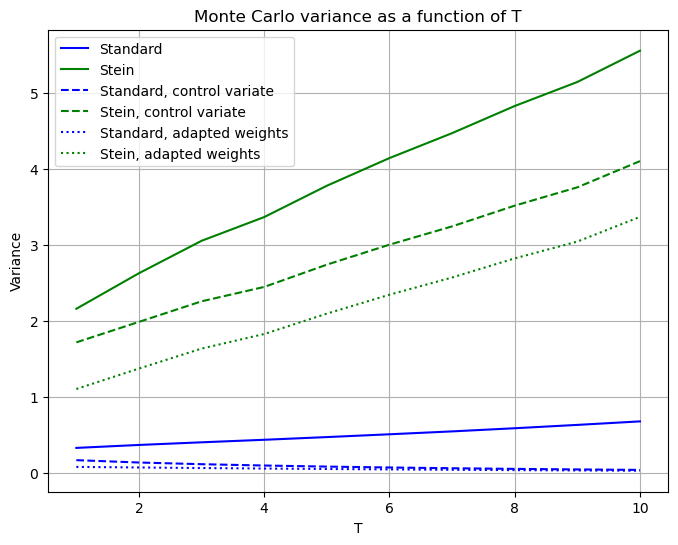

In [8]:
rng = np.random.default_rng(seed=42)
fig, ax = plt.subplots(figsize=(8, 6))

n_sample = 10**6

S0 = 100
T_grid = np.arange(1, 11)

r = 0.05
sigma = 0.2
model = Black76(sigma, r)

phi = payoff_call
grad_phi = grad_payoff_call

plot_variance(phi, grad_phi, n_sample, T_grid, S0, model, rng, ax)

Le graph montre que la variance de la premier estimateur a toujours la meilleur variance qui semble contredire les résultats obtenus dans le cours.

Mais là on a borné la variance en supposant que $\phi$ est bornée. Donc il fout considerer un fontion borner pour démontrer les avantages de deuxieme approche. On considère un call-spread:
$$
\phi(x) = \dfrac{1}{\varepsilon}((x - (K - \varepsilon))^+ - (x - K)^+) \leq 1.
$$

Analytic delta: 0.00872149682663459
Standard method: 0.008745 ± 5.8e-05
Standard method with c.v.: 0.008745 ± 5.8e-05
Standard method, adopted c.v. weights: 0.008745 ± 5.8e-05
Method using Stein lemma: 0.008719 ± 8e-06
Method using Stein lemma with c.v.: 0.008718 ± 8e-06
Method using Stein, adopted c.v. weights: 0.008719 ± 4e-06


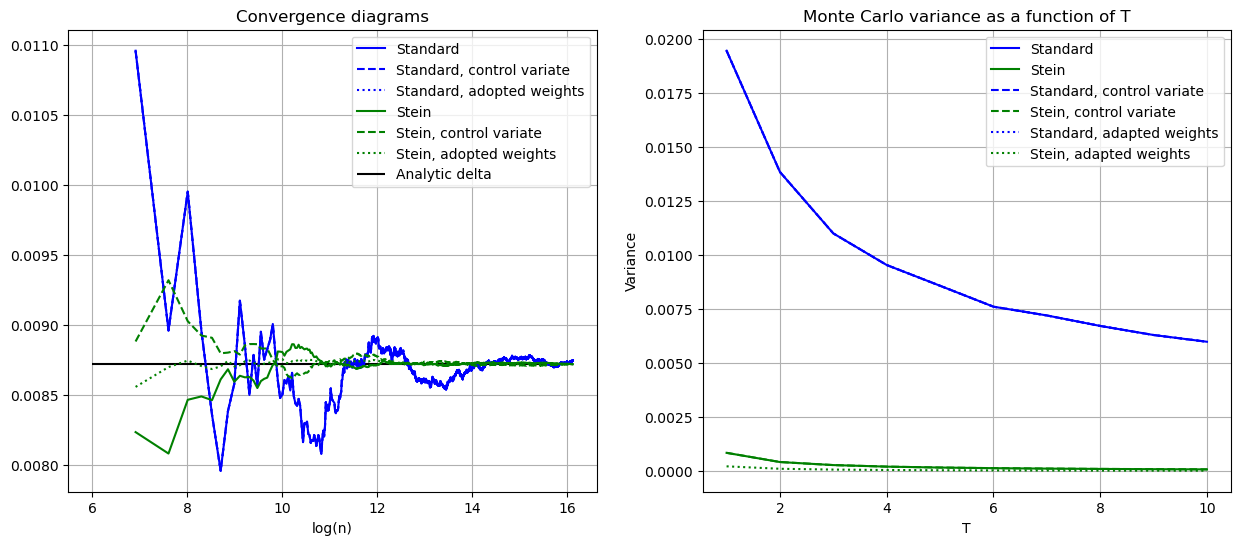

In [9]:
rng = np.random.default_rng(seed=42)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

n_sample = 10**7

r = 0
sigma = 0.2
model = Black76(sigma, r)

S0 = np.exp(-r * T) * K
T = 5
F0 = S0 * np.exp(r*T)

call_spread_step = 1
delta = (model.delta(T, K - call_spread_step, F0, 'c') - model.delta(T, K, F0, 'c')) / call_spread_step
print('Analytic delta:', delta)
ax[0].hlines(delta, 6, np.log(n_sample), 'k', label='Analytic delta')

phi = lambda x: (payoff_call(x, K - call_spread_step) - payoff_call(x, K)) / call_spread_step
grad_phi = lambda x: (grad_payoff_call(x, K - call_spread_step) - grad_payoff_call(x, K)) / call_spread_step
estimate_delta(
    phi=phi,
    grad_phi=grad_phi,
    n_sample=n_sample,
    T=T,
    S0=S0,
    model=model,
    rng=rng,
    ax=ax[0]
)

T_grid = np.arange(1, 11)
n_sample = 10**6
plot_variance(phi, grad_phi, n_sample, T_grid, S0, model, rng, ax[1])